In [61]:
import sys, glob, os
from commons import convert_to_json, triq_optimization, qiskit_optimization, \
    calibration_type_enum, qiskit_compilation_enum, normalize_counts, calculate_success_rate_tvd, \
    convert_dict_binary_to_int, convert_dict_int_to_binary, sum_last_n_digits_dict
import wrappers.qiskit_wrapper as qiskit_wrapper
from wrappers.qiskit_wrapper import QiskitCircuit
import pandas as pd
import mthree
import mapomatic as mm
import mthree

from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.options import SamplerOptions, EstimatorOptions, DynamicalDecouplingOptions, TwirlingOptions

from qiskit_aer import AerSimulator, QasmSimulator, Aer
from qiskit.qasm2 import dumps

from datetime import datetime
import mysql.connector
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

CB_color_cycle = ['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A', '#D62728', '#FF9896',
                  '#9467BD', '#C5B0D5', '#8C564B', '#C49C94', '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7',
                  '#BCBD22', '#DBDB8D', '#17BECF', '#9EDAE5'
                  ]

CB_color_cycle_polar = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

markers = ['o', 'v', 'd', 's', '+', 'x', '^', '*', '<', '>', 'p', '1', '2', '3', '4']
linestyles = ['-', '--', ':', '-.', '-', '--', '-.', ':']
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

#calibration_sets = ["real", "avg", "recent", "decay_r"]
calibration_sets = ["real", "avg"]
# opts = ["TriQ", "SCR"]
# opts = ["TriQ"]



# MySQL connection parameters
mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'localhost',
    'database': 'framework'
}

def get_cx_lines(updated_qasm, two_qubit_gates):
    # Split the code into lines
    lines = updated_qasm.split('\n')

    re_str = r'^\s*{}'.format(two_qubit_gates)
    cx_lines = [line for line in lines if re.match(re_str, line)]
    
    # Create a dictionary to store the counts of normalized 'cx' gates
    cx_counts = {}
    
    # Iterate through the 'cx' lines, normalize, and count them
    for line in cx_lines:
        qubits = re.findall(r'q\[(\d+)\],q\[(\d+)\]', line)
        if len(qubits) == 1:
            qubit1, qubit2 = sorted(map(int, qubits[0]))
            normalized_line = f"({qubit1},{qubit2})"
            
            if normalized_line in cx_counts:
                cx_counts[normalized_line] += 1
            else:
                cx_counts[normalized_line] = 1

    return cx_counts

def get_measure_lines(updated_qasm):
    lines = updated_qasm.split('\n')
    measure_lines = [line for line in lines if re.match(r'^\s*measure', line)]
    return measure_lines

def get_initial_mapping(updated_qasm):
    initial_mappings = []
    measure_lines = get_measure_lines(updated_qasm)
    for line in measure_lines:
        qubits = re.findall(r'q\[(\d+)\] -> c\[(\d+)\]', line)
        if len(qubits) == 1:
            initial_mappings.append(int(qubits[0][0]))

    return initial_mappings

def rename_opt_type(opt_type):
    new_name = opt_type

    if opt_type == "SCR_avg":
        new_name = "SCR_s_1"
    elif opt_type == "SCR_decay_15":
        new_name = "SCR_s_3"
    elif opt_type == "SCR_decay_45":
        new_name = "SCR_s_4"
        
    elif opt_type == "TriQ_avg":
        new_name = "TriQ_s_1"
    elif opt_type == "TriQ_decay_15":
        new_name = "TriQ_s_3"
    elif opt_type == "TriQ_decay_45":
        new_name = "TriQ_s_4"
        
    return new_name



In [37]:
def get_data_scale(user_id, hw_name="ibm_brisbane"):
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()

    
    sql = """
    SELECT d.created_datetime, circuit_name, compilation_name,
circuit_depth, total_two_qubit_gate, success_rate_tvd, success_rate_quasi, c.qubit, success_rate_polar, d.noise_level,
d.compilation_time, h.dd_enable, h.dd_sequence_type, h.dd_scheduling_method
FROM framework.result_header h
INNER JOIN framework.result_detail d ON h.id = d.header_id
INNER JOIN framework.metric m ON d.id = m.detail_id 
INNER JOIN framework.circuit c ON d.circuit_name = c.name 
WHERE h.status = "done" and h.user_id = {} AND h.hw_name = '{}' ORDER BY qubit, circuit_name ;
    """.format(user_id, hw_name)

     # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()
    
    opt = []
    calibration_type = []
    nassc = []
    tvd = []
    header_id = []
    hellinger = []
    total_gate = []
    total_gate_cx = []
    qubit_gate_count_1q = []
    qubit_gate_count_2q = []
    circuit_depth = []
    circuit_cost = []
    execution_time = []
    success_quasi = []
    success_quasi_std = []
    success_nassc_std = []
    success_polar = []
    cx_counts = []
    initial_mappings = []
    circuit_name = []
    qubit = []
    noise_level = []
    compilation_time = []
    dd_enable = []
    dd_sequence_type = []
    dd_scheduling_method = []

    idx = 0
    for res in results:
        _header_id, _circuit_name, opt_type, _circuit_depth, _qubit_gate_count_2q, _success_tvd,  \
        _success_quasi, _qubit, _success_polar, _noise_level, _compilation_time, \
        _dd_enable, _dd_sequence_type, _dd_scheduling_method = res
            
        header_id.append(_header_id)
        circuit_name.append(_circuit_name)
        opt.append(rename_opt_type(opt_type))
        circuit_depth.append(float(_circuit_depth))
        qubit_gate_count_2q.append(float(_qubit_gate_count_2q))
        tvd.append(float(_success_tvd))
        success_quasi.append(float(_success_quasi))

        if _success_polar != None:
            success_polar.append(float(_success_polar))
        else:
            success_polar.append(float(0))
        
        qubit.append(float(_qubit))
        noise_level.append(_noise_level)
        compilation_time.append(_compilation_time)

        tmp_dd_enable = 0
        if _dd_enable == 1:
            tmp_dd_enable = 1
        
        dd_enable.append(tmp_dd_enable)
        dd_sequence_type.append(_dd_sequence_type)
        dd_scheduling_method.append(_dd_scheduling_method)

    df = pd.DataFrame({
        'header_id': header_id,
        'circuit_name': circuit_name,
        'opt': opt,
        'circuit_depth': circuit_depth,
        'qubit_gate_count_2q': qubit_gate_count_2q,
        'TVD': tvd, 
        'quasi': success_quasi, 
        'qubit': qubit,
        #'polar': success_polar,
        #'noise_level': noise_level,
        #'compilation_time': compilation_time,
        'dd_enable': dd_enable,
        'dd_seq_type': dd_sequence_type,
        'dd_sch_method': dd_scheduling_method,
        })

    return df

In [72]:
def show_summary_bar_lines(df, opts, legends, circuits, ylim, ylabel, figsize=(12,5), 
                           width = 0.08, show_legend = True, legend_position = None, color_idx_add = 0):
    
    fig, ax = plt.subplots(figsize=figsize)
    width = width
    x = np.arange(len(circuits))
    
    for i, opt in enumerate(opts):
        if i == 0:
            color_idx_add = 0
        else:
            color_idx_add = 2

        idx_normal = i * 2
        idx_dd = (i * 2) + 1
        
        opt_data = df[(df['opt'] == opt) & (df['dd_enable'] == 0)]
        #print(opt)
        #print(opt_data)
        rects = ax.bar(x + idx_normal * width, opt_data['mean'], yerr=opt_data['std'], color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2)

        opt_data_dd = df[(df['opt'] == opt) & (df['dd_enable'] == 1)]
        rects = ax.bar(x + idx_dd * width, opt_data_dd['mean'], yerr=opt_data_dd['std'], color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2, hatch=hatches[1])
    
    ax.set_ylabel(ylabel)
    # ax.set_title('Mean Success rate with STD by Circuit and Opt')
    ax.set_xticks(x + width * (len(opts) - 1) / 2)
    ax.set_xticklabels(circuits)
    ax.grid(axis='y')
    if show_legend:
        if legend_position == None:
            ax.legend(legends)
        else:
            ax.legend(legends, loc = legend_position)
    else:
        ax.legend([])
        
    plt.ylim(ylim)
    plt.show()

## Brisbane

In [83]:
df_bris = get_data_scale(2, "ibm_brisbane")
df_bris.head()

,header_id,circuit_name,opt,circuit_depth,qubit_gate_count_2q,TVD,quasi,qubit,dd_enable,dd_seq_type,dd_sch_method
0,2024-07-04 11:48:25,bv_2,sabre_triq_lcd,25.0,1.0,0.97050,0.97050,2.0,1,XpXm,alap
1,2024-07-03 23:54:25,bv_2,sabre_triq_lcd,25.0,1.0,0.97200,0.97200,2.0,1,XpXm,alap
2,2024-07-04 11:47:58,bv_2,sabre_triq_lcd,25.0,1.0,0.96725,0.96725,2.0,0,None,None
3,2024-07-04 11:48:24,bv_2,sabre_triq_avg,25.0,1.0,0.97600,0.97600,2.0,1,XpXm,alap
4,2024-07-03 23:53:52,bv_2,sabre_triq_lcd,25.0,1.0,0.97275,0.97275,2.0,0,None,None


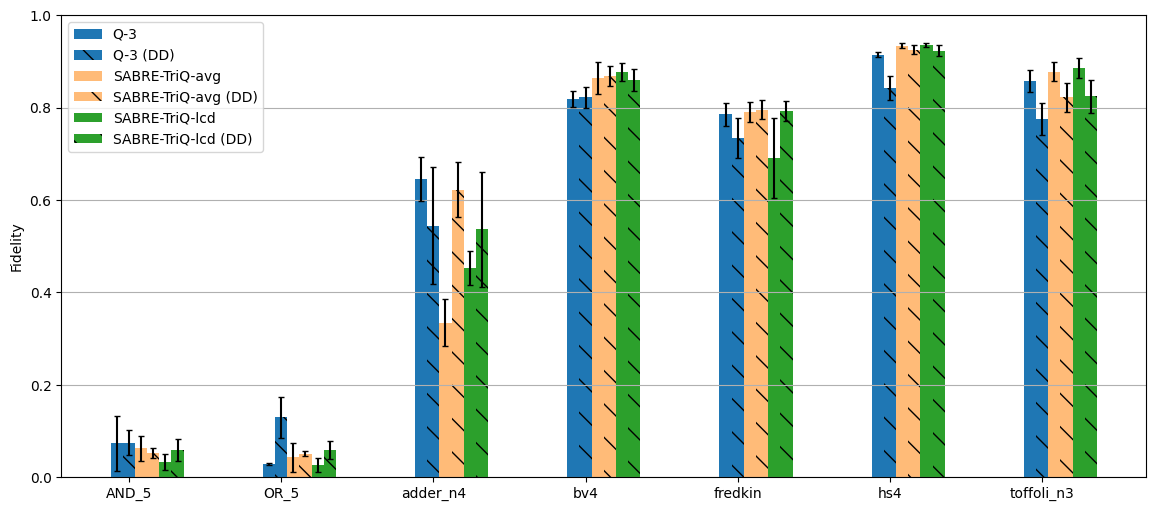

In [84]:
df_bris_cal = df_bris.loc[((df_bris['circuit_name'] == 'adder_n4') | (df_bris['circuit_name'] == 'AND_5')
| (df_bris['circuit_name'] == 'bv4') | (df_bris['circuit_name'] == 'fredkin')
| (df_bris['circuit_name'] == 'hs4') | (df_bris['circuit_name'] == 'OR_5')
| (df_bris['circuit_name'] == 'toffoli_n3')
                          )]

df_bris_cal_summary = df_bris_cal.groupby(['circuit_name', 'opt', "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_bris_cal_circuits = df_bris_cal_summary['circuit_name'].unique()
opts = df_bris_cal_summary['opt'].unique()
#print(opts)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_bris_cal_summary, opts, legends, df_bris_cal_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

['bv_2' 'bv_3' 'bv_4' 'bv_5' 'bv_6' 'bv_7' 'bv_8' 'bv_9' 'bv_10' 'bv_11'
 'bv_12']


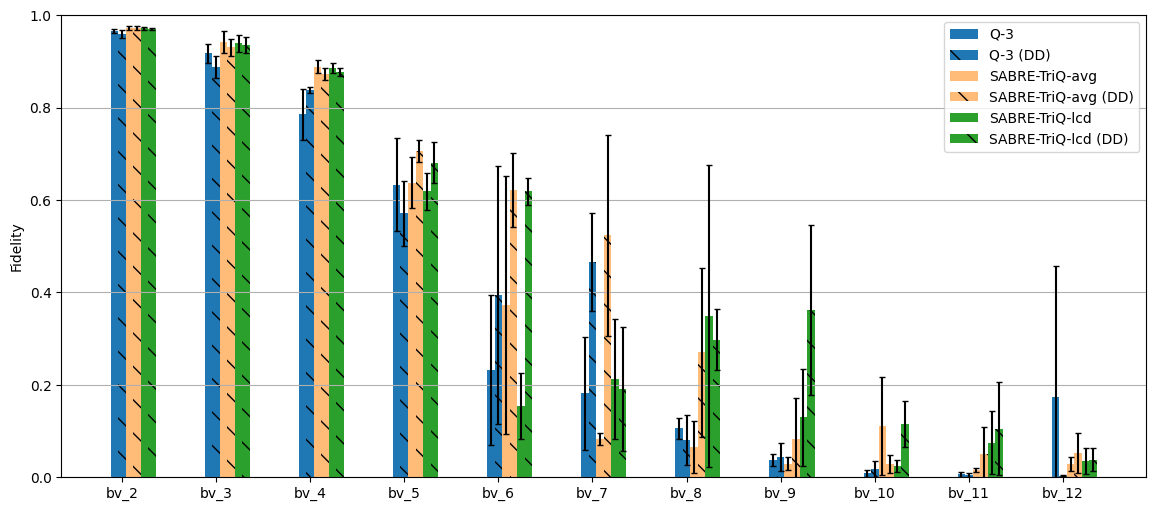

In [85]:
df_bris_bv = df_bris.loc[((df_bris['circuit_name'] == 'bv_2') | (df_bris['circuit_name'] == 'bv_3')
| (df_bris['circuit_name'] == 'bv_4') | (df_bris['circuit_name'] == 'bv_5') | (df_bris['circuit_name'] == 'bv_6')
| (df_bris['circuit_name'] == 'bv_7')| (df_bris['circuit_name'] == 'bv_8')| (df_bris['circuit_name'] == 'bv_9')
| (df_bris['circuit_name'] == 'bv_10')| (df_bris['circuit_name'] == 'bv_11')| (df_bris['circuit_name'] == 'bv_12')
                          )]

df_bris_bv_summary = df_bris_bv.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_bris_bv_summary = df_bris_bv_summary.sort_values(by='qubit', ascending=True)

df_bris_bv_circuits = df_bris_bv_summary['circuit_name'].unique()
opts = df_bris_bv_summary['opt'].unique()

print(df_bris_bv_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_bris_bv_summary, opts, legends, df_bris_bv_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

['adder_n4' 'adder_n7' 'adder_n10']


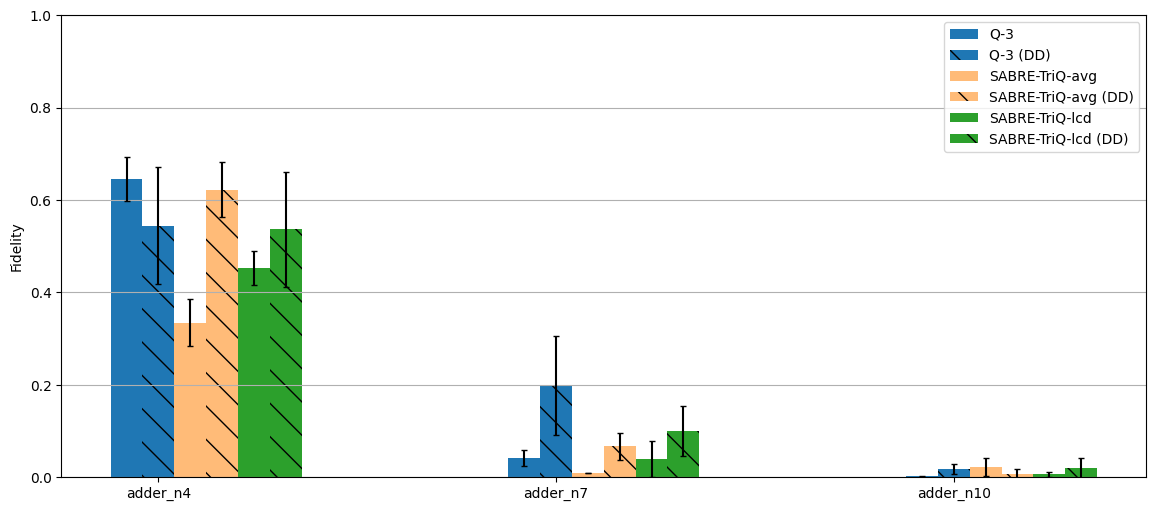

In [86]:
df_bris_add = df_bris.loc[((df_bris['circuit_name'] == 'adder_n4') | (df_bris['circuit_name'] == 'adder_n7')
| (df_bris['circuit_name'] == 'adder_n10') 
                          )]

df_bris_add_summary = df_bris_add.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_bris_add_summary = df_bris_add_summary.sort_values(by='qubit', ascending=True)

df_bris_add_circuits = df_bris_add_summary['circuit_name'].unique()
opts = df_bris_add_summary['opt'].unique()

print(df_bris_add_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_bris_add_summary, opts, legends, df_bris_add_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

## Sherbrooke

In [87]:
df_sher = get_data_scale(2, "ibm_sherbrooke")
df_sher.head()

,header_id,circuit_name,opt,circuit_depth,qubit_gate_count_2q,TVD,quasi,qubit,dd_enable,dd_seq_type,dd_sch_method
0,2024-07-03 23:36:39,bv_2,qiskit_3,63.0,1.0,0.97525,0.97525,2.0,0,None,None
1,2024-07-04 11:44:26,bv_2,sabre_triq_avg,25.0,1.0,0.97200,0.97200,2.0,1,XpXm,alap
2,2024-07-04 11:44:01,bv_2,sabre_triq_lcd,25.0,1.0,0.97500,0.97500,2.0,0,None,None
3,2024-07-03 23:52:41,bv_2,sabre_triq_lcd,25.0,1.0,0.97325,0.97325,2.0,1,XpXm,alap
4,2024-07-04 11:44:26,bv_2,qiskit_3,63.0,1.0,0.96675,0.96675,2.0,1,XpXm,alap


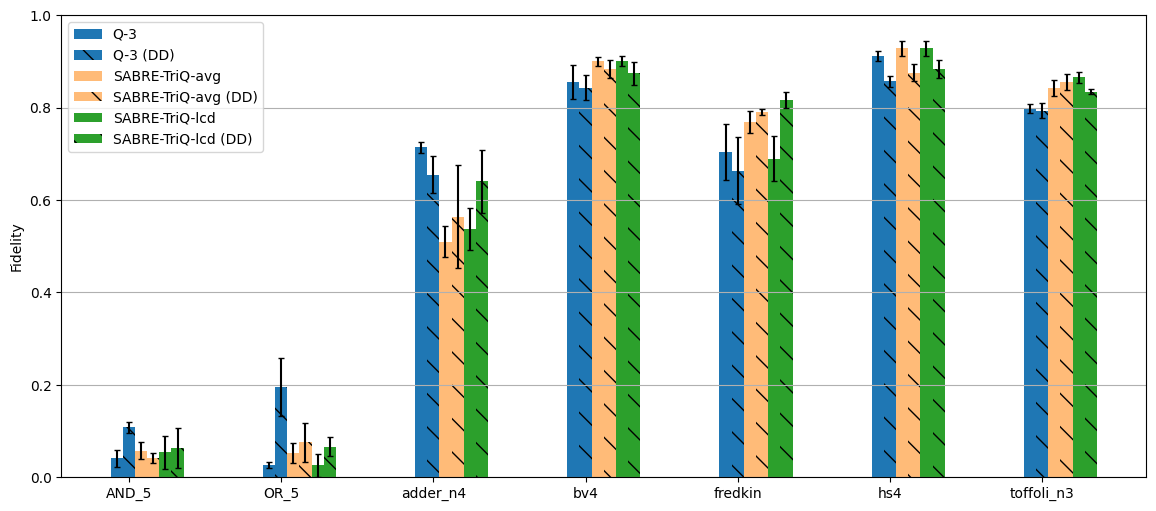

In [88]:
df_sher_cal = df_sher.loc[((df_sher['circuit_name'] == 'adder_n4') | (df_sher['circuit_name'] == 'AND_5')
| (df_sher['circuit_name'] == 'bv4') | (df_sher['circuit_name'] == 'fredkin')
| (df_sher['circuit_name'] == 'hs4') | (df_sher['circuit_name'] == 'OR_5')
| (df_sher['circuit_name'] == 'toffoli_n3')
                          )]

df_sher_cal_summary = df_sher_cal.groupby(['circuit_name', 'opt', "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_sher_cal_circuits = df_sher_cal_summary['circuit_name'].unique()
opts = df_sher_cal_summary['opt'].unique()
#print(opts)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_sher_cal_summary, opts, legends, df_sher_cal_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

['bv_2' 'bv_3' 'bv_4' 'bv_5' 'bv_6' 'bv_7' 'bv_8' 'bv_9' 'bv_10' 'bv_11'
 'bv_12']


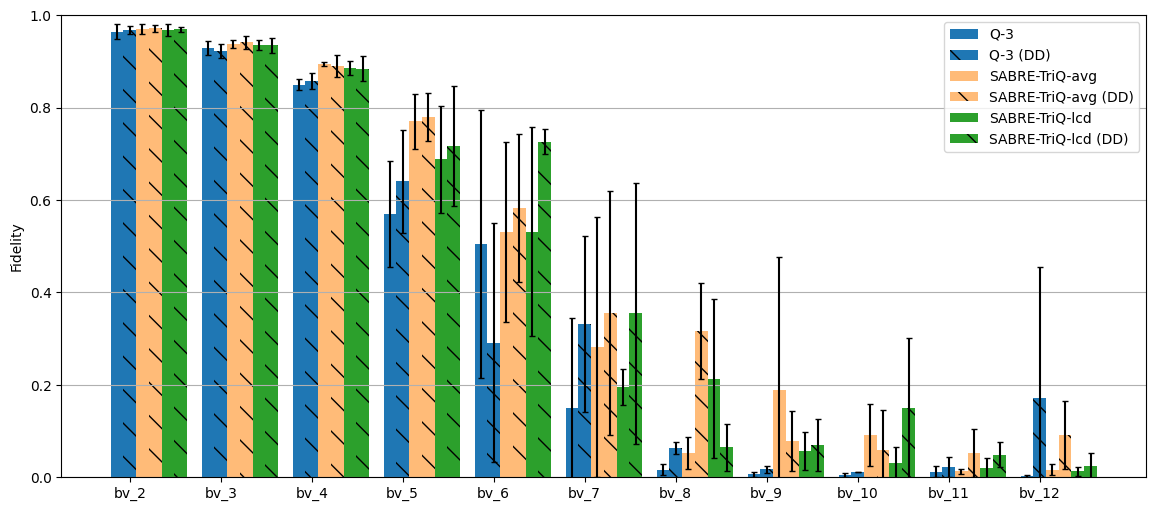

In [93]:
df_sher_bv = df_sher.loc[((df_sher['circuit_name'] == 'bv_2') | (df_sher['circuit_name'] == 'bv_3')
| (df_sher['circuit_name'] == 'bv_4') | (df_sher['circuit_name'] == 'bv_5') | (df_sher['circuit_name'] == 'bv_6')
| (df_sher['circuit_name'] == 'bv_7')| (df_sher['circuit_name'] == 'bv_8')| (df_sher['circuit_name'] == 'bv_9')
| (df_sher['circuit_name'] == 'bv_10')| (df_sher['circuit_name'] == 'bv_11')| (df_sher['circuit_name'] == 'bv_12')
                          )]

df_sher_bv_summary = df_sher_bv.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_sher_bv_summary = df_sher_bv_summary.sort_values(by='qubit', ascending=True)

df_sher_bv_circuits = df_sher_bv_summary['circuit_name'].unique()
opts = df_sher_bv_summary['opt'].unique()

print(df_sher_bv_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_sher_bv_summary, opts, legends, df_sher_bv_circuits, [0,1], "Fidelity", width=0.14, figsize=(14,6))

['adder_n4' 'adder_n7' 'adder_n10']


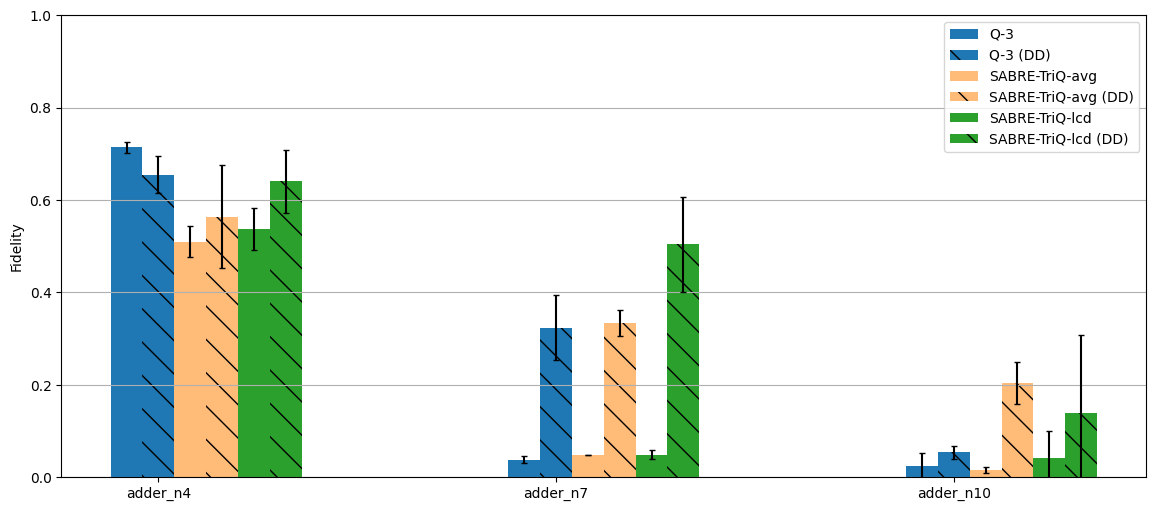

In [90]:
df_sher_add = df_sher.loc[((df_sher['circuit_name'] == 'adder_n4') | (df_sher['circuit_name'] == 'adder_n7')
| (df_sher['circuit_name'] == 'adder_n10') 
                          )]

df_sher_add_summary = df_sher_add.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_sher_add_summary = df_sher_add_summary.sort_values(by='qubit', ascending=True)

df_sher_add_circuits = df_sher_add_summary['circuit_name'].unique()
opts = df_sher_add_summary['opt'].unique()

print(df_sher_add_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_sher_add_summary, opts, legends, df_sher_add_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))